In [6]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

%matplotlib inline

Original arrangement:  ['data/img4.jpg', 'data/img3.jpg', 'data/img2.jpg', 'data/img1.jpg']
Sorted arrangement:  ['data/img1.jpg', 'data/img2.jpg', 'data/img3.jpg', 'data/img4.jpg']


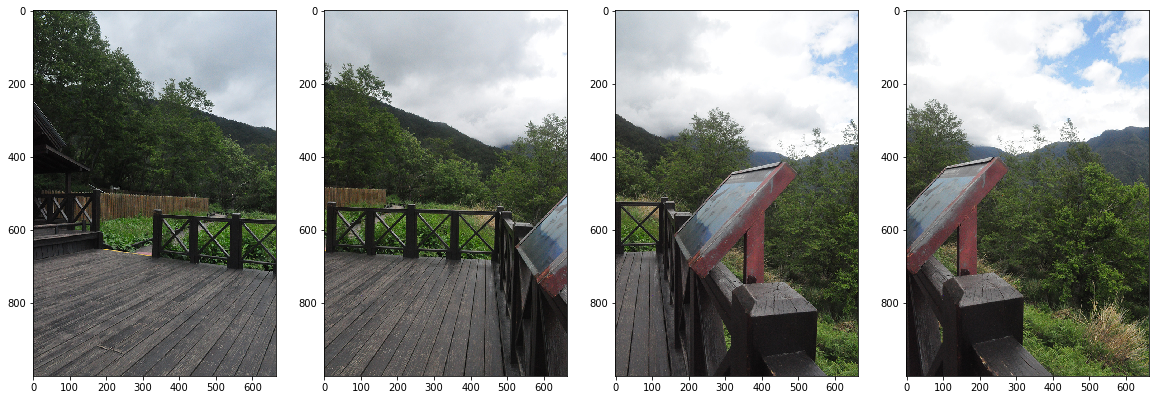

In [9]:
# (1) Load successive images (successive frames: [ fr0, fr1, fr2, fr3 ])

# Note: (taken from same viewpoint center but if the points are faw away, it does not matter much)
# Note: data source => https://github.com/SSARCandy/panoramas-image-stitching/tree/master/input_image/Xue-Mountain-Enterance

root = 'data'
files = []
for filename in os.listdir(root):
    files.append(os.path.join(root, filename))

print('Original arrangement: ', files)
# sort them in reverse
files = files[::-1]
print('Sorted arrangement: ', files)

frames = []
for idx in range(len(files)):
    frames.append(cv2.cvtColor(cv2.imread(files[idx], cv2.IMREAD_ANYCOLOR), cv2.COLOR_BGR2RGB).astype(np.uint8))

N = len(frames)
fig, axes = plt.subplots(1, N, figsize=(20, 20))
for idx in range(N):
    axes[idx].imshow(frames[idx])

Number of pairs: 213


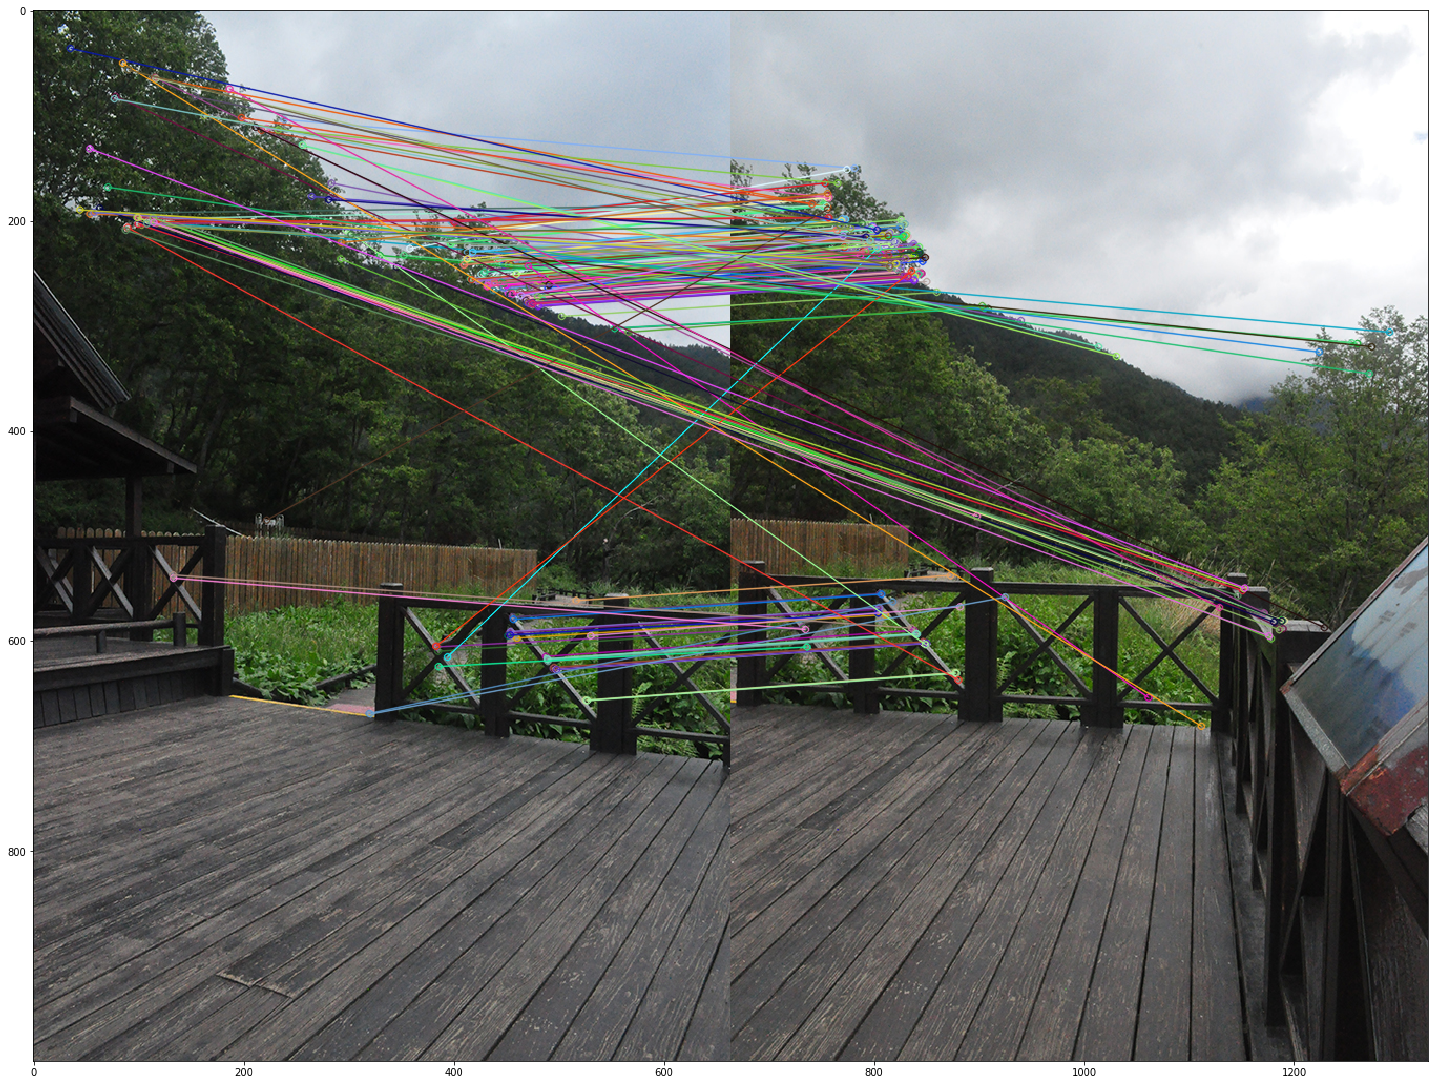

In [11]:
# (2) Find corresponding points in successive frames (relative to base frame, fr0)

orb = cv2.ORB_create()

# Note: Descriptors are rotation invariant
kpnts0, descs0 = orb.detectAndCompute(frames[0], None)
kpnts1, descs1 = orb.detectAndCompute(frames[1], None)

distance_matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

matches = distance_matcher.match(descs0, descs1)
matches = sorted(matches, key=lambda m: m.distance)

print(f'Number of pairs: {len(matches)}')

result = cv2.drawMatches(frames[0], kpnts0, frames[1], kpnts1, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(25, 25))
plt.imshow(result)

0 => 482.4000244140625 x 259.20001220703125 - 174.0 x 232.8000030517578
20 => 489.6000061035156 x 619.2000122070312 - 176.40000915527344 x 594.0
40 => 474.8544616699219 x 259.2000427246094 - 167.9616241455078 x 234.31683349609375
60 => 485.22247314453125 x 275.7888488769531 - 178.32962036132812 x 250.9056396484375
80 => 450.3860168457031 x 261.2736511230469 - 141.8342742919922 x 231.413818359375
100 => 441.6000061035156 x 237.60000610351562 - 133.20001220703125 x 207.60000610351562
120 => 416.4000244140625 x 255.60000610351562 - 108.00000762939453 x 224.40000915527344
140 => 456.19207763671875 x 269.5680236816406 - 150.3360137939453 x 243.6480255126953
160 => 54.0 x 193.0 - 76.72321319580078 x 184.55043029785156
180 => 99.5328140258789 x 203.21282958984375 - 487.0 x 552.0
200 => 98.5374984741211 x 197.0749969482422 - 488.1600341796875 x 550.0800170898438


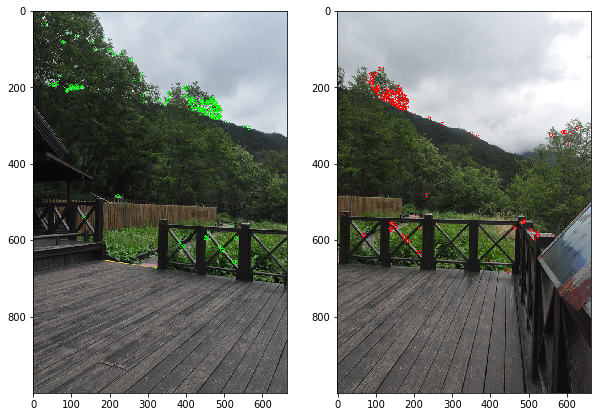

In [21]:
# (2.1) Manage the matching pairs
correspondances = []
for idx in range(len(matches)):
    match = matches[idx]
    pnt1 = kpnts0[match.queryIdx]
    pnt2 = kpnts1[match.trainIdx]
    x1, y1 = pnt1.pt
    x2, y2 = pnt2.pt
    correspondances.append([x1, y1, x2, y2])
    
    if idx % 20 == 0:
        print(f'{idx} => {x1} x {y1} - {x2} x {y2}')
    
base = np.copy(frames[0])
for pnts in correspondances:
    base = cv2.circle(base, (int(pnts[0]), int(pnts[1])), 5, (0, 255, 0))
    
frame = np.copy(frames[1])
for pnts in correspondances:
    frame = cv2.circle(frame, (int(pnts[2]), int(pnts[3])), 5, (255, 0, 0))

fig, axes = plt.subplots(1, 2, figsize=(10, 10))
axes[0].imshow(base)
axes[1].imshow(frame)

In [ ]:
# (3) Clean outliers (mismatches) via RANSAC
